<a href="https://colab.research.google.com/github/joaochenriques/IST_MCTE/blob/main/StreamTurbines/BladeDesign_V03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import subprocess
import pandas as pd
import pathlib
import numpy as np
from scipy.optimize import minimize

def cmdcall( cmd, verbose = False ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import matplotlib.pyplot as mpl
import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

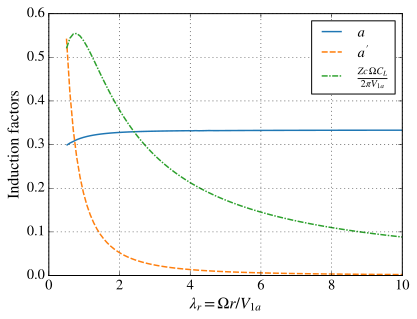

In [18]:
def tip_loss( a, ap, λr, λtip, Z ):
    ϕ  = np.arctan( ( 1 - a ) / ( 1 + ap ) / λr )
    return 2.0 / np.pi * np.arccos( np.exp( Z / ( 2.0 * np.sin(ϕ) * ( 1 - λtip / λr ) ) ) )

def f_objective( X, λr ):
    a  = X[0]
    ap = X[1]
    fO = ( 1.0 - a ) * ap * λr**3
    return -fO

def f_constraint( X, λr ):
    a  = X[0]
    ap = X[1]
    fC = ( 1.0 + ap ) * ap * λr**2 - ( 1.0 - a ) * a
    return fC

rad2deg = 180/np.pi
deg2rad = np.pi/180

λr_vec = []
ϕ_vec = []
a_vec = []
ap_vec = []
CP_vec = []
EE_vec = []

X0 = ( 0.2, 1 )

# λr_set = np.concatenate( ( np.linspace( 0.25, 2.0, 8 ), np.linspace( 2.5, 6.0, 8 ), np.linspace( 7, 12,6 ) ) )
λr_set = np.linspace( 0.5, 10, 100 )

for λr in λr_set:
    f_objt = lambda X : f_objective( X, λr )
    f_cons = lambda X : f_constraint( X, λr )

    cons = [ { 'type': 'eq', 'fun': f_cons } ]
    sol = minimize( f_objt, X0, method = 'SLSQP', constraints = cons )
    X0 = sol.x

    a  = X0[0]
    ap = X0[1]
    ϕ  = np.arctan( ( 1 - a ) / ( 1 + ap ) / λr )
    CP = ap * ( 1.0 - a ) * λr**3
    EE = 4.0 * ap * λr**2 / np.sqrt( (1-a)**2 + (1+ap)**2 * λr**2 )

    λr_vec.append( λr )
    a_vec.append( a )
    ap_vec.append( ap )
    ϕ_vec.append( ϕ * rad2deg )
    CP_vec.append( CP )
    EE_vec.append( EE )

mpl.plot( λr_vec, a_vec, label  = r"$a$" )
mpl.plot( λr_vec, ap_vec, label = r"$a'$" )
mpl.plot( λr_vec, EE_vec, label = r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$" )
mpl.xlabel( r"$\lambda_r=\Omega r/V_{1a}$")
mpl.ylabel( "Induction factors")
mpl.legend()
mpl.grid()
mpl.savefig( "InductionFactors.pdf" )

In [16]:
df = pd.DataFrame( { r"$\lambda_r$": λr_vec,
                     r"$a$": np.round(a_vec,decimals=5),
                     r"$a'$": np.round(ap_vec,decimals=5),
                     r"$\phi$": np.round(ϕ_vec, decimals=2),
                     r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$": np.round(EE_vec, decimals=5)
                    } )

# print( df.to_latex(index=False,
#                   formatters={"name": str.upper},
#                   float_format="{:.5f}".format,
# ))
df

,$\lambda_r$,$a$,$a'$,$\phi$,"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$"
0,0.500000,0.29836,0.54277,42.29,0.52052
1,0.545455,0.30088,0.47827,40.93,0.53334
2,0.590909,0.30321,0.42470,39.61,0.54279
3,0.636364,0.30533,0.37964,38.35,0.54929
4,0.681818,0.30744,0.34144,37.13,0.55341
...,...,...,...,...,...
95,4.818182,0.33216,0.00947,7.82,0.17904
96,4.863636,0.33218,0.00929,7.75,0.17747
97,4.909091,0.33220,0.00912,7.68,0.17592
98,4.954545,0.33222,0.00896,7.61,0.17439


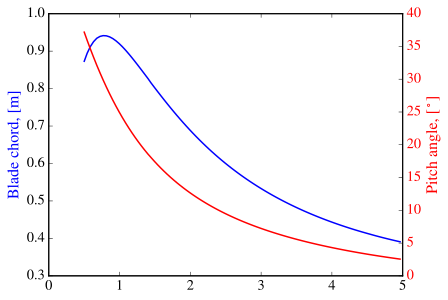

In [4]:
V1a = 2.5
Ω = 24.0 * np.pi / 30.0
Z = 3

α = 5 * deg2rad
CL = 1.30
CD = 0.05

r_vec = []
c_vec = []
θ_vec = []
Ct_vec = []
σt_vec = []

for λr, a, ap, ϕ in zip( λr_vec, a_vec, ap_vec, ϕ_vec ):

    ϕ = ϕ * deg2rad
    θ = ϕ - α

    # Ca = CL * np.cos(ϕ) + CD * np.sin(ϕ)
    # σa = a / ( 1 - a ) * 4.0 * np.sin(ϕ)**2 / Ca

    Ct = CL * np.sin(ϕ) - CD * np.cos(ϕ)
    σt = ap / ( 1 + ap ) * 4.0 * np.sin(ϕ) * np.cos(ϕ) / Ct

    r = λr * V1a / Ω
    c = σt * 2.0 * np.pi * r / Z

    r_vec.append( r )
    c_vec.append( c )
    θ_vec.append( θ * rad2deg )
    Ct_vec.append( Ct )
    σt_vec.append( σt )

    # print( f"r = {r:6.3f}, ϕ = {ϕ:6.3f}, Ct = {Ct:8.4f}, σt = {σt:6.3f}, c = {c:6.3f}, θ = {θ*rad2deg:.2f}" )

mpl.plot( r_vec, c_vec, "b", label="$c$" )
mpl.ylabel( "Blade chord, [m]", color="b" )

ax2 = mpl.gca().twinx()
ax2.plot( r_vec, θ_vec, 'r', label=r'$\theta$' )
ax2.tick_params(axis='y', labelcolor='r' )
ax2.set_ylabel( "Pitch angle, [$^\circ$]", color='r' );

In [5]:
def params( X, r ):

    ϕ = X[0]
    c = X[1]
    Z = 3
    σ = Z * c / ( 2 * np.pi * r )

    CL = 1.4
    CD = 0.0
    k = 1.0

    Ca = CL * np.cos(ϕ) + CD * np.sin(ϕ)
    Ct = CL * np.sin(ϕ) - CD * np.cos(ϕ)

    a  = ( σ * Ca ) / ( 4.0 * k * np.sin(ϕ)**2 + σ * Ca )
    ap = ( σ * Ct ) / ( 4.0 * k * np.sin(ϕ)*np.cos(ϕ) - σ * Ct )

    return k, a, ap

def objective( X, r ):
    ϕ = X[0]
    c = X[1]
    k, a, ap = params( X, r )
    fO = k * ap * ( 1.0 - a ) * r**3
    return -fO

def constraint( X, r ):
    ϕ = X[0]
    c = X[1]
    V1a = 2.25
    Ω = 15 * np.pi / 30.0
    k, a, ap = params( X, r )
    fC = np.tan( ϕ ) - ( 1.0 - a ) / ( 1.0 + ap ) * ( V1a / Ω * r )
    return fC

In [6]:
X0 = ( 0.1, 0.5 )

ϕ_bound = ( 0.0, np.pi/2.0 )
c_bound = ( 0.1, 50.0 )

r = 16.0
bnds = ( ϕ_bound, c_bound )
cons = [ { 'type': 'eq', 'fun': lambda X: constraint( X, r ) } ]

sol = minimize( lambda X: objective( X, r ), X0, method = 'SLSQP', bounds = bnds, constraints = cons )

print(sol)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -28994.84138216747
       x: [ 1.018e+00  4.548e+01]
     nit: 18
     jac: [-5.155e+05 -6.540e+03]
    nfev: 58
    njev: 18


In [7]:
sol.x

array([ 1.01812776, 45.48199215])